## Pasnascope Pipeline

Integrates all of the modules from the package, to go from raw data to csv output.
More information about each module can be found in the other Jupyter Notebooks.
You should change the `experiment name` and the `img_path` at the fist cell.

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from tifffile import imread

from pasnascope import activity, roi, find_hatching, slice_img, utils, vnc_length

experiment_name = '20240503'
root_dir = Path.cwd().parent
project_dir = root_dir.joinpath('data', experiment_name)

# Provide absolute paths for the raw image
img_path = '/home/cdp58/Documents/raw_images/pasnascope/20240503.tif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Visualize the regions of the individual embryos that will be cropped.
If the bounding boxes don't fit the embryo, you can try changing the `thres_adjust` parameter at line 1.
The resulting image also shows the number that will be used for each embryo when saving the individual movies.

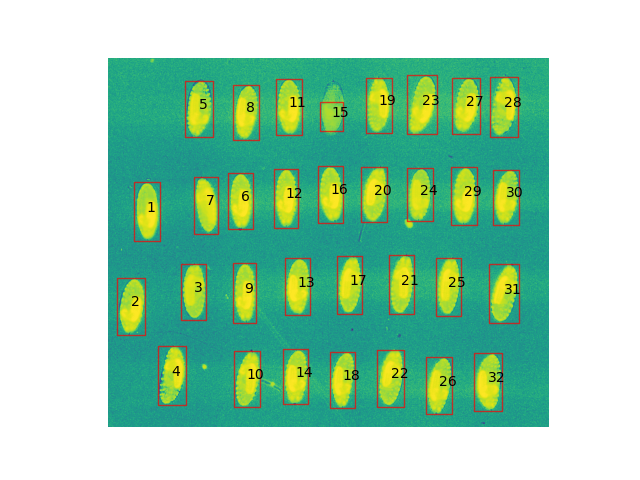

In [29]:
boundaries = slice_img.calculate_slice_coordinates(img_path,n_cols=9, thres_adjust=-10)
img = slice_img.get_first_image_from_mmap(img_path)

rect_coords = [slice_img.boundary_to_rect_coords(b, img.shape) for b in boundaries]
recs = [Rectangle((y,x), w, h) for (x,y,w,h) in rect_coords]

centroids = [((x0+x1)//2, (y0+y1)//2) for (x0, x1, y0, y1) in boundaries]
h = img.shape[0]
w = img.shape[1]

# Visualize the slices before parsing the data:
# The img is equalized just to display the entire embryo
fig, ax = plt.subplots()
fig.canvas.header_visible = False
fig.canvas.resizable = False
ax.set_axis_off()

ax.imshow(img)

pc = PatchCollection(recs, color='red', alpha=0.7, linewidth=1, facecolor='none')
ax.add_collection(pc)

for i, (y, x) in enumerate(centroids):
    ax.text(x, y, str(i+1))

plt.show()

If the image above looks good, change the variable `should_process` to `True` and run the next cell.
This will crop each embryo and save under the `data` directory. 

In [30]:
dest = root_dir.joinpath('data', experiment_name, 'embs')
should_process = False

if should_process:
    dest.mkdir(parents=True, exist_ok=True)
    slice_img.cut_movies(boundaries[:5], img_path, dest, overwrite=False)

emb1-ch1.tif already found. To overwrite the file, pass `overwrite=True`.
emb1-ch2.tif already found. To overwrite the file, pass `overwrite=True`.
Processing emb2-ch1...
Processing emb2-ch2...
Processing emb3-ch1...
Processing emb3-ch2...
Processing emb4-ch1...
Processing emb4-ch2...
Processing emb5-ch1...
Processing emb5-ch2...


Calculate the VNC length for each embryo, and save as a csv file in the `results` directory.

In [31]:
def get_length_centerline(file_path, hp, interval=20):
    '''Measures VNC length, without masking.'''
    img = imread(file_path, key=range(0,hp, interval))
    return vnc_length.measure_VNC_centerline(img)


interval = 20
img_dir = project_dir.joinpath('embs')
embs = sorted(img_dir.glob('*ch2.tif'), key=utils.sort_by_emb_name)

dest = root_dir.joinpath('results', experiment_name)
dest.mkdir(parents=True, exist_ok=True)
file_path = dest.joinpath('lengths.csv')

lengths = []
hatching_points = {}

for emb in embs:
    print(emb.stem)
    hp = find_hatching.find_hatching_point(emb)
    hp -= hp % interval
    hatching_points[emb.stem] = hp

    vnc_len = get_length_centerline(emb, hp, interval=interval)
    lengths.append(vnc_len)

vnc_length.export_csv(embs, lengths, file_path, interval)
print(f"Wrote length data for {len(embs)} embryos, at {file_path}")

emb1-ch2
1740
emb2-ch2
1760
emb3-ch2
2280
emb4-ch2
1820
emb5-ch2
2520
{'emb1-ch2': 1740, 'emb2-ch2': 1760, 'emb3-ch2': 2280, 'emb4-ch2': 1820, 'emb5-ch2': 2520}


In [32]:
img_dir = project_dir.joinpath( 'embs')

# All structural channel movies end with the suffix ch2
active = sorted(img_dir.glob('*ch1.tif'), key=utils.sort_by_emb_name)
struct = sorted(img_dir.glob('*ch2.tif'), key=utils.sort_by_emb_name)

In [33]:
file_name = 'activity.csv'
# The roi is calculated in steps of `window` size.
# This means that the slices from 0 to 10 will use the same 
# roi, that was calculated based on frame 0, for example.
window = 10

dest = root_dir.joinpath('results', experiment_name)
dest.mkdir(parents=True, exist_ok=True)
file_path = dest.joinpath(file_name)

if file_path.exists():
    print("The file {file_path.stem} already exists, and won't be overwritten. Change file or delete the existing file.")
else:
    embryos = []
    for i, act in enumerate(active):
        print(act.stem)
        if act.stem in hatching_points:
            hp = hatching_points[act.stem]
        else:
            hp = find_hatching.find_hatching_point(struct[i])
        hp -= hp % window

        active_img = imread(active[i], key=range(hp))
        struct_img = imread(struct[i], key=range(hp))
        mask = roi.get_roi(struct_img, window=window)

        masked_active = activity.apply_mask(active_img, mask)
        masked_struct = activity.apply_mask(struct_img, mask)

        signal_active = activity.get_activity(masked_active)
        signal_struct = activity.get_activity(masked_struct)

        emb = [signal_active, signal_struct]

        embryos.append(emb)


    activity.export_csv(embryos, file_path)
    print(f"Wrote activity data for {len(embryos)} embryos, at {file_path}")


Wrote activity data for 5 embryos, at /home/cdp58/Documents/repos/pasnascope/results/new_expp/activity.csv
